In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
file_names=[]
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        file_names.append(filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
file_names.sort()
#print(file_names)

In [4]:
json_file=[]
for i in range(351):
    k=f"2022-08-24 ({i}).png___pixel.json"
    json_file.append(k)
updated_file=[]
for i in range(len(file_names)):
    if file_names[i] not in json_file and file_names[i]!='classes.json' and file_names[i] !='www.acmeai.tech ODataset 4 - Cricket Semantic Segmentation.pdf':
        updated_file.append(file_names[i])
    

In [5]:
print(len(updated_file))

895


In [6]:
#print(updated_file)

In [6]:
original_image=[]
fused_image=[]
saved_image=[]
for i in range(len(updated_file)):
    if updated_file[i].endswith("png___save.png"):
      
        saved_image.append(updated_file[i])
    elif updated_file[i].endswith("png___fuse.png"):
     
        fused_image.append(updated_file[i])
        
    elif updated_file[i].endswith(".png"):
     
        original_image.append(updated_file[i])
    
    
 

In [7]:
print(len(original_image))
print(len(fused_image))
print(len(saved_image))

298
298
298


In [8]:
#now here we make a function to read the image 
import matplotlib.pyplot as plt

#lets create a function that takes in the image size of 1080,1920 and resizes it to 256,256,1
from PIL import Image
import numpy as np
def resize_image(z):
    link="/kaggle/input/cricket-semantic-segmentation/www.acmeai.tech ODataset 4 - Cricket Semantic Segmentation/images/"+z
    z1=plt.imread(link)
    
    z1=z1[:,:,0]
    z1 = (z1 * 255).astype(np.uint8)
    
    image = Image.fromarray(z1)
    resized_image=image.resize((256,256))
    
    resized_image=np.asarray(resized_image)
    
    #print(resized_image)
    return resized_image

    

In [9]:

def read_image(z):
    resized_image=resize_image(z)

    
    plt.imshow(resized_image)
    print(resized_image.shape)
    plt.show()


(256, 256)


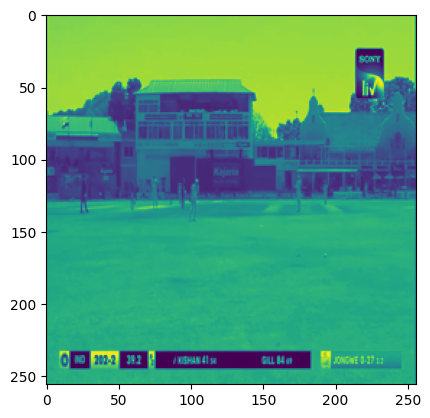

In [10]:
read_image(original_image[1])

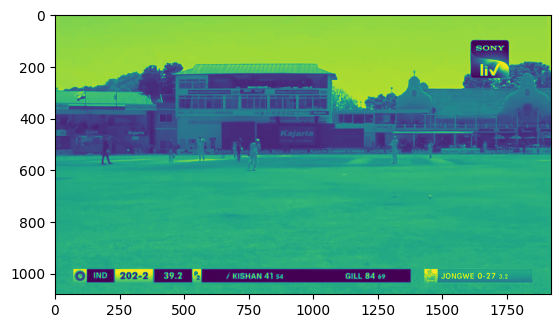

In [11]:
import matplotlib.pyplot as plt
k="/kaggle/input/cricket-semantic-segmentation/www.acmeai.tech ODataset 4 - Cricket Semantic Segmentation/images/"+str(original_image[1])
image=plt.imread(k)
image=image[:,:,0]
plt.imshow(image)
plt.show()

In [12]:
#now lets create our semantic segmentation model 
#we import the dependencies 
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from PIL import Image
from IPython.display import display


2024-06-20 17:25:06.298356: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 17:25:06.298469: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 17:25:06.407035: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:


class unet():
    def __init__(self):
        self.input_size = (256, 256, 1)
        self.activation = 'relu'
        self.padding = 'same'
        self.kernel_size = 3
        
    def downsampling_block(self, x, frames):
        y = layers.Conv2D(frames, self.kernel_size, padding=self.padding, activation=self.activation)(x)
        z = layers.Conv2D(frames, self.kernel_size, padding=self.padding, activation=self.activation)(y)
        maxpool_1 = layers.MaxPool2D()(z)
        return z, maxpool_1
        
    def upsampling_block(self, x, frames, y):
        c1 = layers.Conv2DTranspose(frames, 2, strides=(2, 2), padding=self.padding)(x)
        d1 = layers.Conv2D(frames, self.kernel_size, activation='relu', padding='same')(c1)
        d1 = layers.Add()([y, d1])
        d1_1 = layers.Conv2D(frames, self.kernel_size, activation='relu', padding='same')(d1)
        d1_2 = layers.Conv2D(frames, self.kernel_size, activation='relu', padding='same')(d1_1)
        return d1_2
        
    def build_model(self):
        input_layer = layers.Input((256, 256, 1))
        
        a = self.downsampling_block(input_layer, 128)
        b = self.downsampling_block(a[1], 64)
        
        c = self.downsampling_block(b[1], 32)
        
        d = self.downsampling_block(c[1], 16)
        
        e = self.upsampling_block(d[0], 32, c[0])
        
        f = self.upsampling_block(e, 64, b[0])
        output1 = self.upsampling_block(f, 128, a[0])
        
        downsampling1=layers.Conv2D(1,1,activation='sigmoid',padding='same')(output1)
        
        model = Model(inputs=input_layer, outputs=downsampling1)
        self.model = model
        
        return self.model
    
    def plot_model(self):
        plot_model(self.model, show_layer_names=True, show_shapes=True, to_file='model.png')
        display(Image.open('model.png'))
        
    def model_summary(self):
        self.model.summary()
        
    def compile_model(self):
        self.model.compile(metrics=['accuracy'], loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),run_eagerly=True)


    

In [14]:
#now lets differentiate our data into the train and the test set 
train_set=[]
train_segmented=[]

test_set=[]
test_segmented=[]

'''
original_image=[]
fused_image=[]
saved_image=[]
'''
for i in range(len(original_image)):
    if i<250:
        train_set.append(resize_image(original_image[i]))
        train_segmented.append(resize_image(saved_image[i]))
    else:
        test_set.append(resize_image(original_image[i]))
        test_segmented.append(resize_image(saved_image[i]))
        
train_set=np.asarray(train_set)
train_segmented=np.asarray(train_segmented)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,280 │ input_layer[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │    147,584 │ conv2d[0][0]      │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,792 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,464 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_4[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │      4,624 │ max_pooling2d_2[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │      2,320 │ conv2d_6[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │      2,080 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_transpose… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ conv2d_5[0][0],   │
│                     │ 32)               │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │      9,248 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │      9,248 │ conv2d_9[0][0]  

 Total params: 918,881 (3.51 MB)

 Trainable params: 918,881 (3.51 MB)

 Non-trainable params: 0 (0.00 B)

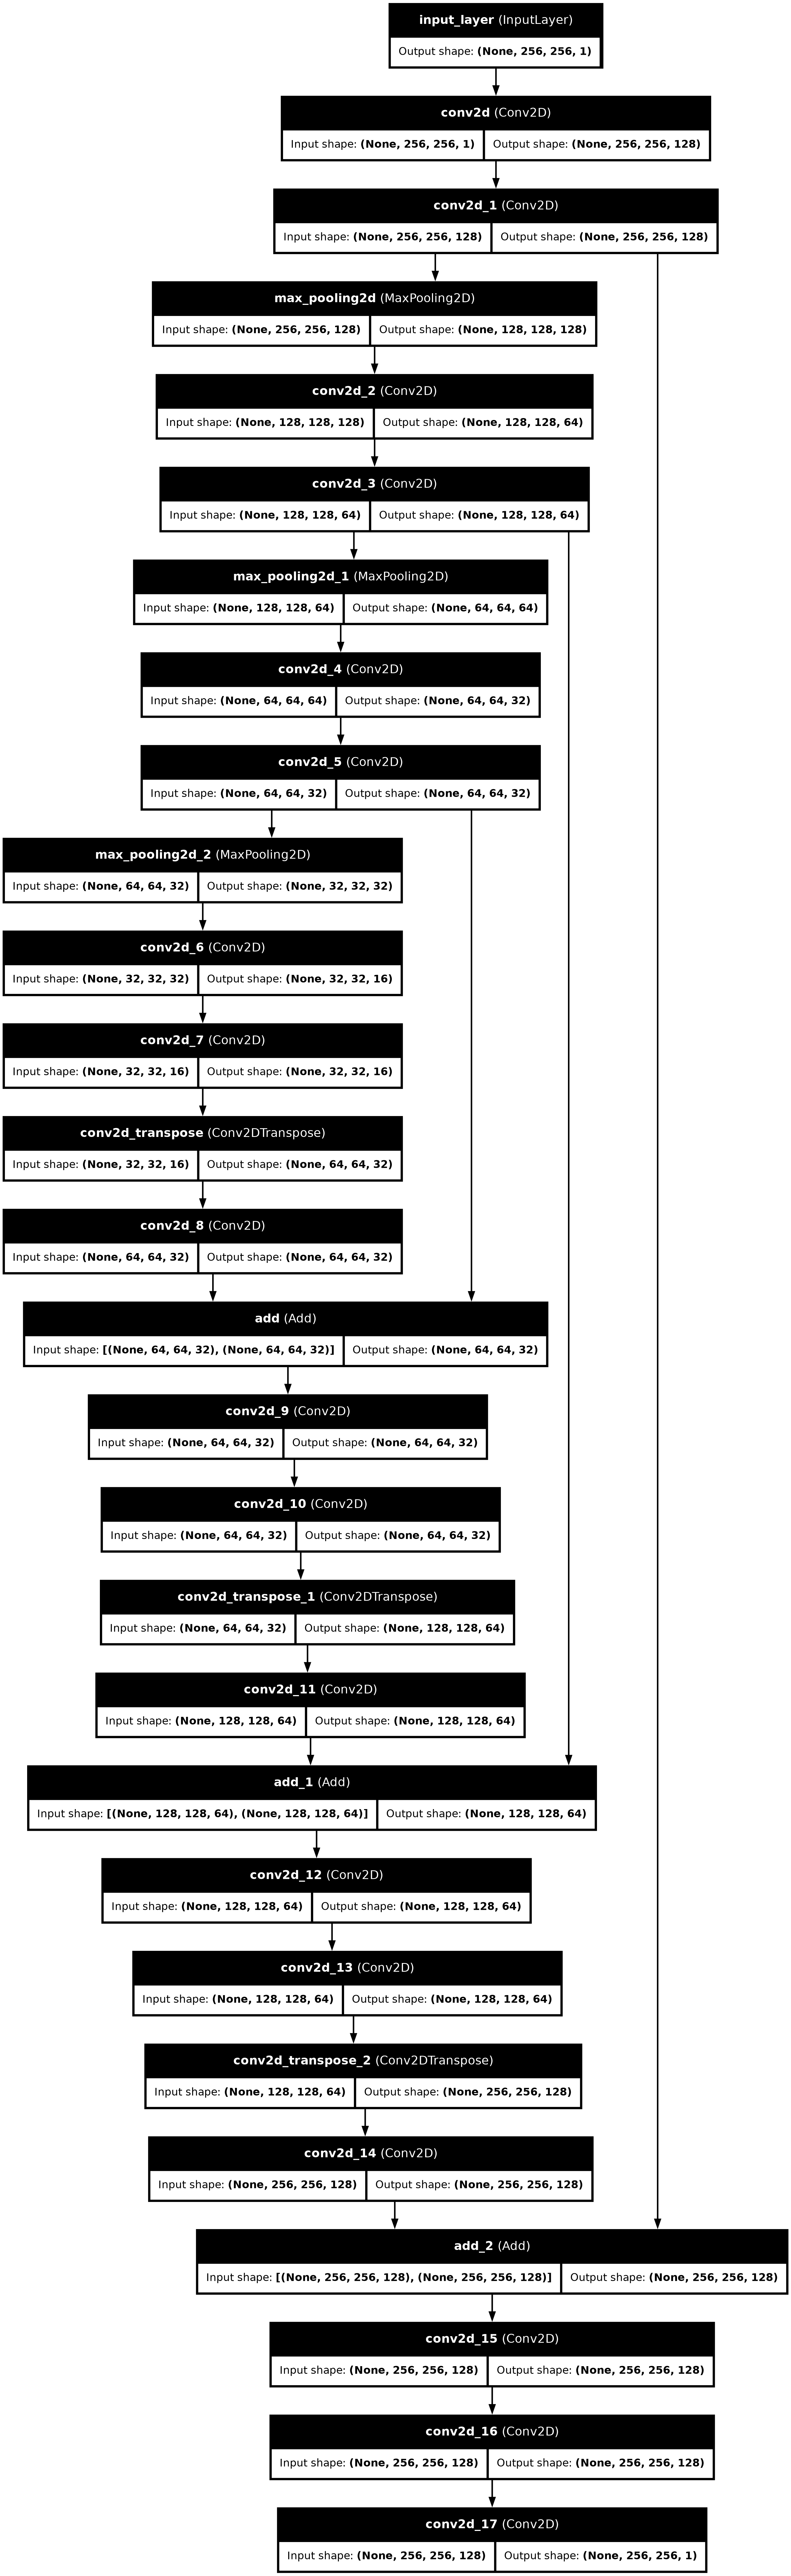

In [15]:
#now lets create an instance of the model 
unet_model = unet()
model = unet_model.build_model()
unet_model.compile_model()
unet_model.model_summary()
unet_model.plot_model()

In [37]:
model.fit(train_set,train_segmented,batch_size=1,verbose=1,epochs=10)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 1.0000 - loss: 1.1921e-07


In [41]:
test_set=np.asarray(test_set)
test_segmented=np.asarray(test_segmented)


In [42]:
model.evaluate(test_set,test_segmented,verbose=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.2707 - loss: 11.6266


[10.0310697555542, 0.3707923889160156]

In [43]:
print(test_set[1].shape)

(256, 256)


In [44]:
image=test_set[1]
# Ensure dtype and shape are correct
image = np.expand_dims(image, axis=0)  # Add batch dimension
#image = image.astype('float32')  # Ensure data type is float32


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


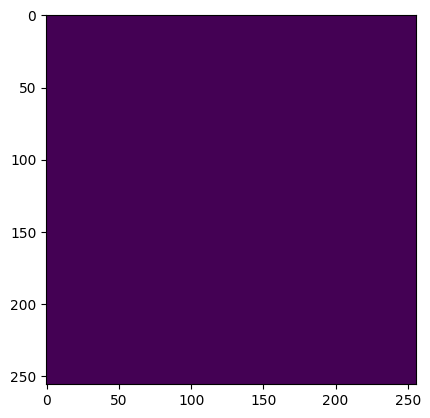

In [45]:
z=model.predict(image)
z= np.squeeze(z, axis=0)
plt.imshow(z)